In [31]:
from Samplers.sampler_test import *
from Samplers.plotting import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, invwishart, dirichlet
from tqdm import tqdm
import matplotlib.patches as patches
import matplotlib.pyplot as plt

data = pd.read_csv('data/NHANES_adults_data_preprocessed.csv')
filtered_data = data[(data['sex'] == 2) & (data['age'] >= 40) & (data['age'] < 60)]
filtered_data = data[(data['sex'] == 2) & (data['age'] >= 40) & (data['age'] < 60)]
cleaned_data = filtered_data[
    (filtered_data['bmi'] >= 10) & (filtered_data['bmi'] <= 80) &
    (filtered_data['sbp'] >= 70) & (filtered_data['sbp'] <= 270)
]
bmi_sbp_data = cleaned_data[['bmi', 'sbp']]

In [32]:
mean_bmi = bmi_sbp_data['bmi'].mean()
mean_sbp = bmi_sbp_data['sbp'].mean()
std_bmi = bmi_sbp_data['bmi'].std()
std_sbp = bmi_sbp_data['sbp'].std()
bmi_sbp_data.loc[:, 'bmi'] = (bmi_sbp_data['bmi'] - mean_bmi) / std_bmi
bmi_sbp_data.loc[:, 'sbp'] = (bmi_sbp_data['sbp'] - mean_sbp) / std_sbp
bmi_bounds = (np.array([18, 25, 30, np.inf])-mean_bmi)/std_bmi
sbp_bounds = (np.array([140, 160, np.inf])-mean_sbp)/std_sbp


In [33]:
from scipy.spatial.distance import pdist

def h1(mu):
    return np.min(pdist(mu))

def h2(mu):
    """
    Returns 1 if unique, 0 otherwise.
    """
    # Extract BMI and SBP values from mu
    bmi = mu[:, 0]
    sbp = mu[:, 1]
    
    # Use np.digitize to find interval indices for BMI and SBP
    bmi_blocks = np.digitize(bmi, bins=bmi_bounds)
    sbp_blocks = np.digitize(sbp, bins=sbp_bounds)
    
    # Combine BMI and SBP block indices into tuples
    blocks = set(zip(bmi_blocks, sbp_blocks))
    
    # If all blocks are unique, return 1; otherwise, return 0
    return 1 if len(blocks) == len(mu) else 0


Running Gibbs Sampler for sigma = 0.001


Sampling: 100%|██████████| 1000/1000 [01:08<00:00, 14.57it/s]


Running Gibbs Sampler for sigma = 0.01


Sampling: 100%|██████████| 1000/1000 [01:08<00:00, 14.67it/s]


Running Gibbs Sampler for sigma = 0.05


Sampling: 100%|██████████| 1000/1000 [03:12<00:00,  5.20it/s] 


Running Gibbs Sampler for sigma = 0.1


Sampling: 100%|██████████| 1000/1000 [01:09<00:00, 14.47it/s]


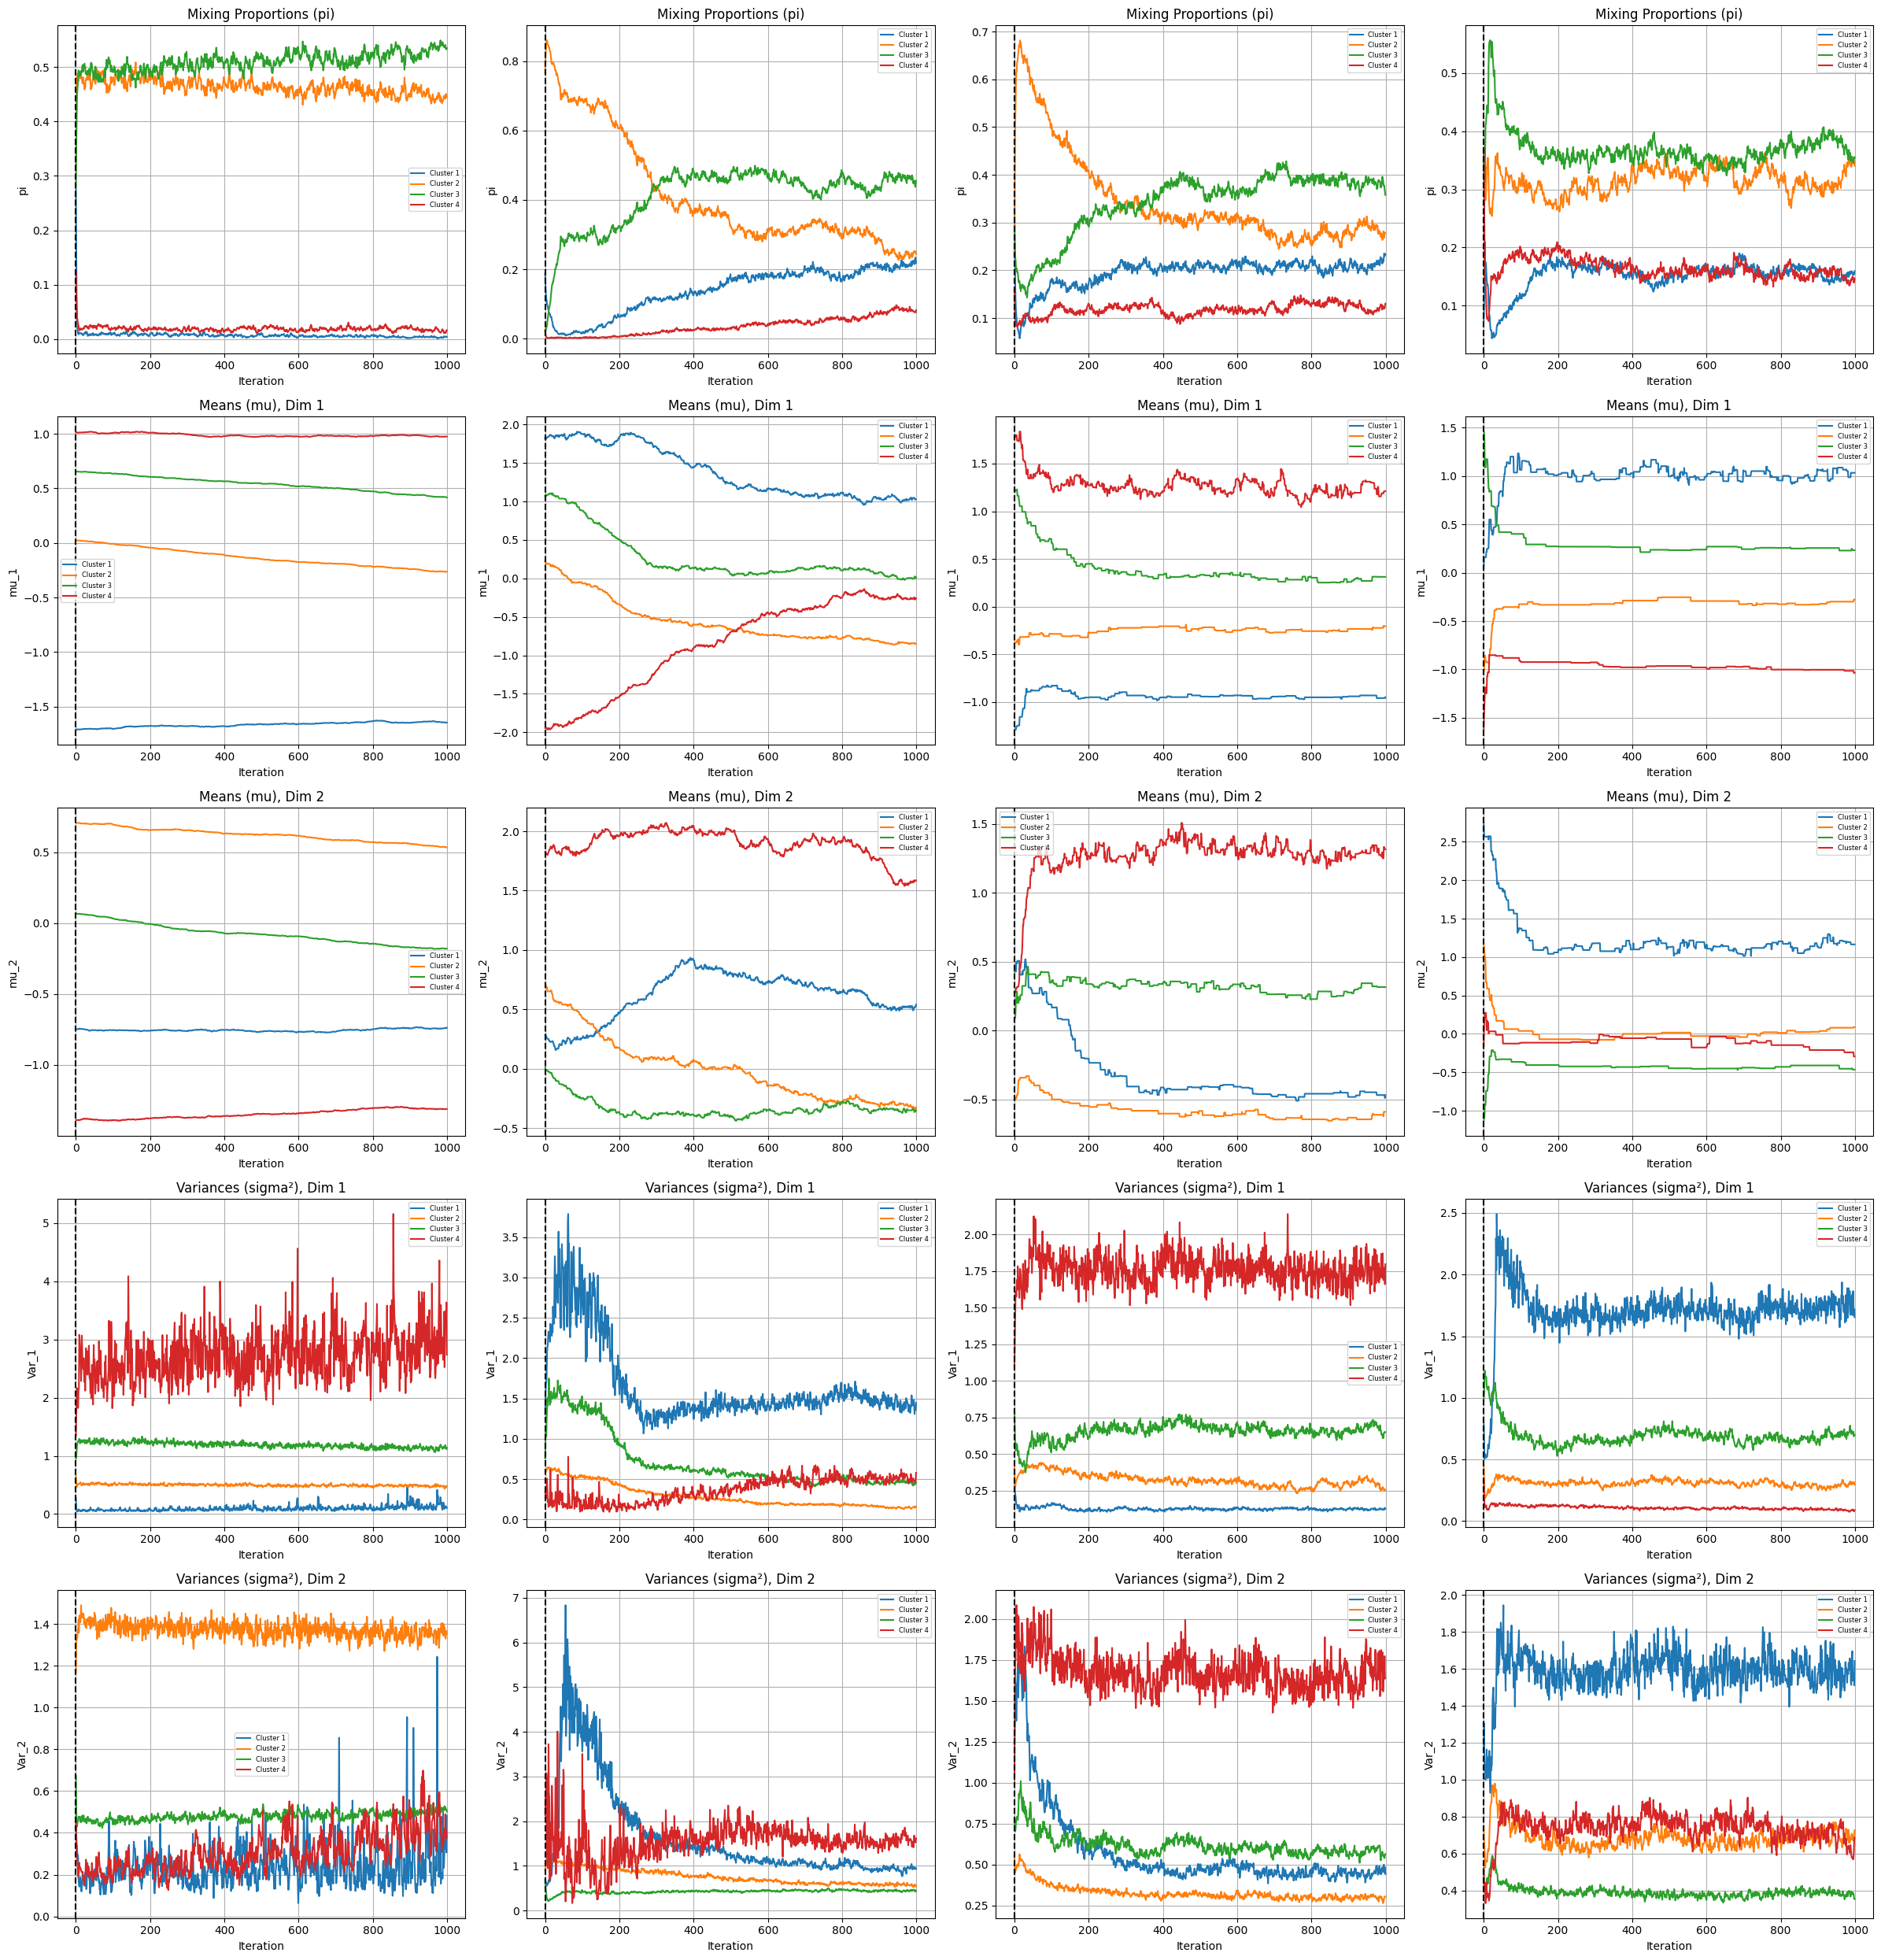

In [34]:
np.random.seed(42)
# Parameters
# num_runs = 4
num_iterations = 1000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 
sigma_vals = [0.001, 0.01, 0.05, 0.1]
num_runs = len(sigma_vals)
all_run_samples = []

for sig in sigma_vals:
    print(f"Running Gibbs Sampler for sigma = {sig}")
    run_samples = bayesian_repulsive_randomwalk(X, K, num_iterations, h1, 0, sig)
    all_run_samples.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=0)
plt.tight_layout()
plt.show()




Running Gibbs Sampler for sigma = 0.01


Sampling: 100%|██████████| 1000/1000 [01:10<00:00, 14.09it/s]


Running Gibbs Sampler for sigma = 0.05


Sampling: 100%|██████████| 1000/1000 [01:10<00:00, 14.26it/s]


Running Gibbs Sampler for sigma = 0.1


Sampling: 100%|██████████| 1000/1000 [01:10<00:00, 14.20it/s]


Running Gibbs Sampler for sigma = 0.15


Sampling: 100%|██████████| 1000/1000 [01:09<00:00, 14.31it/s]


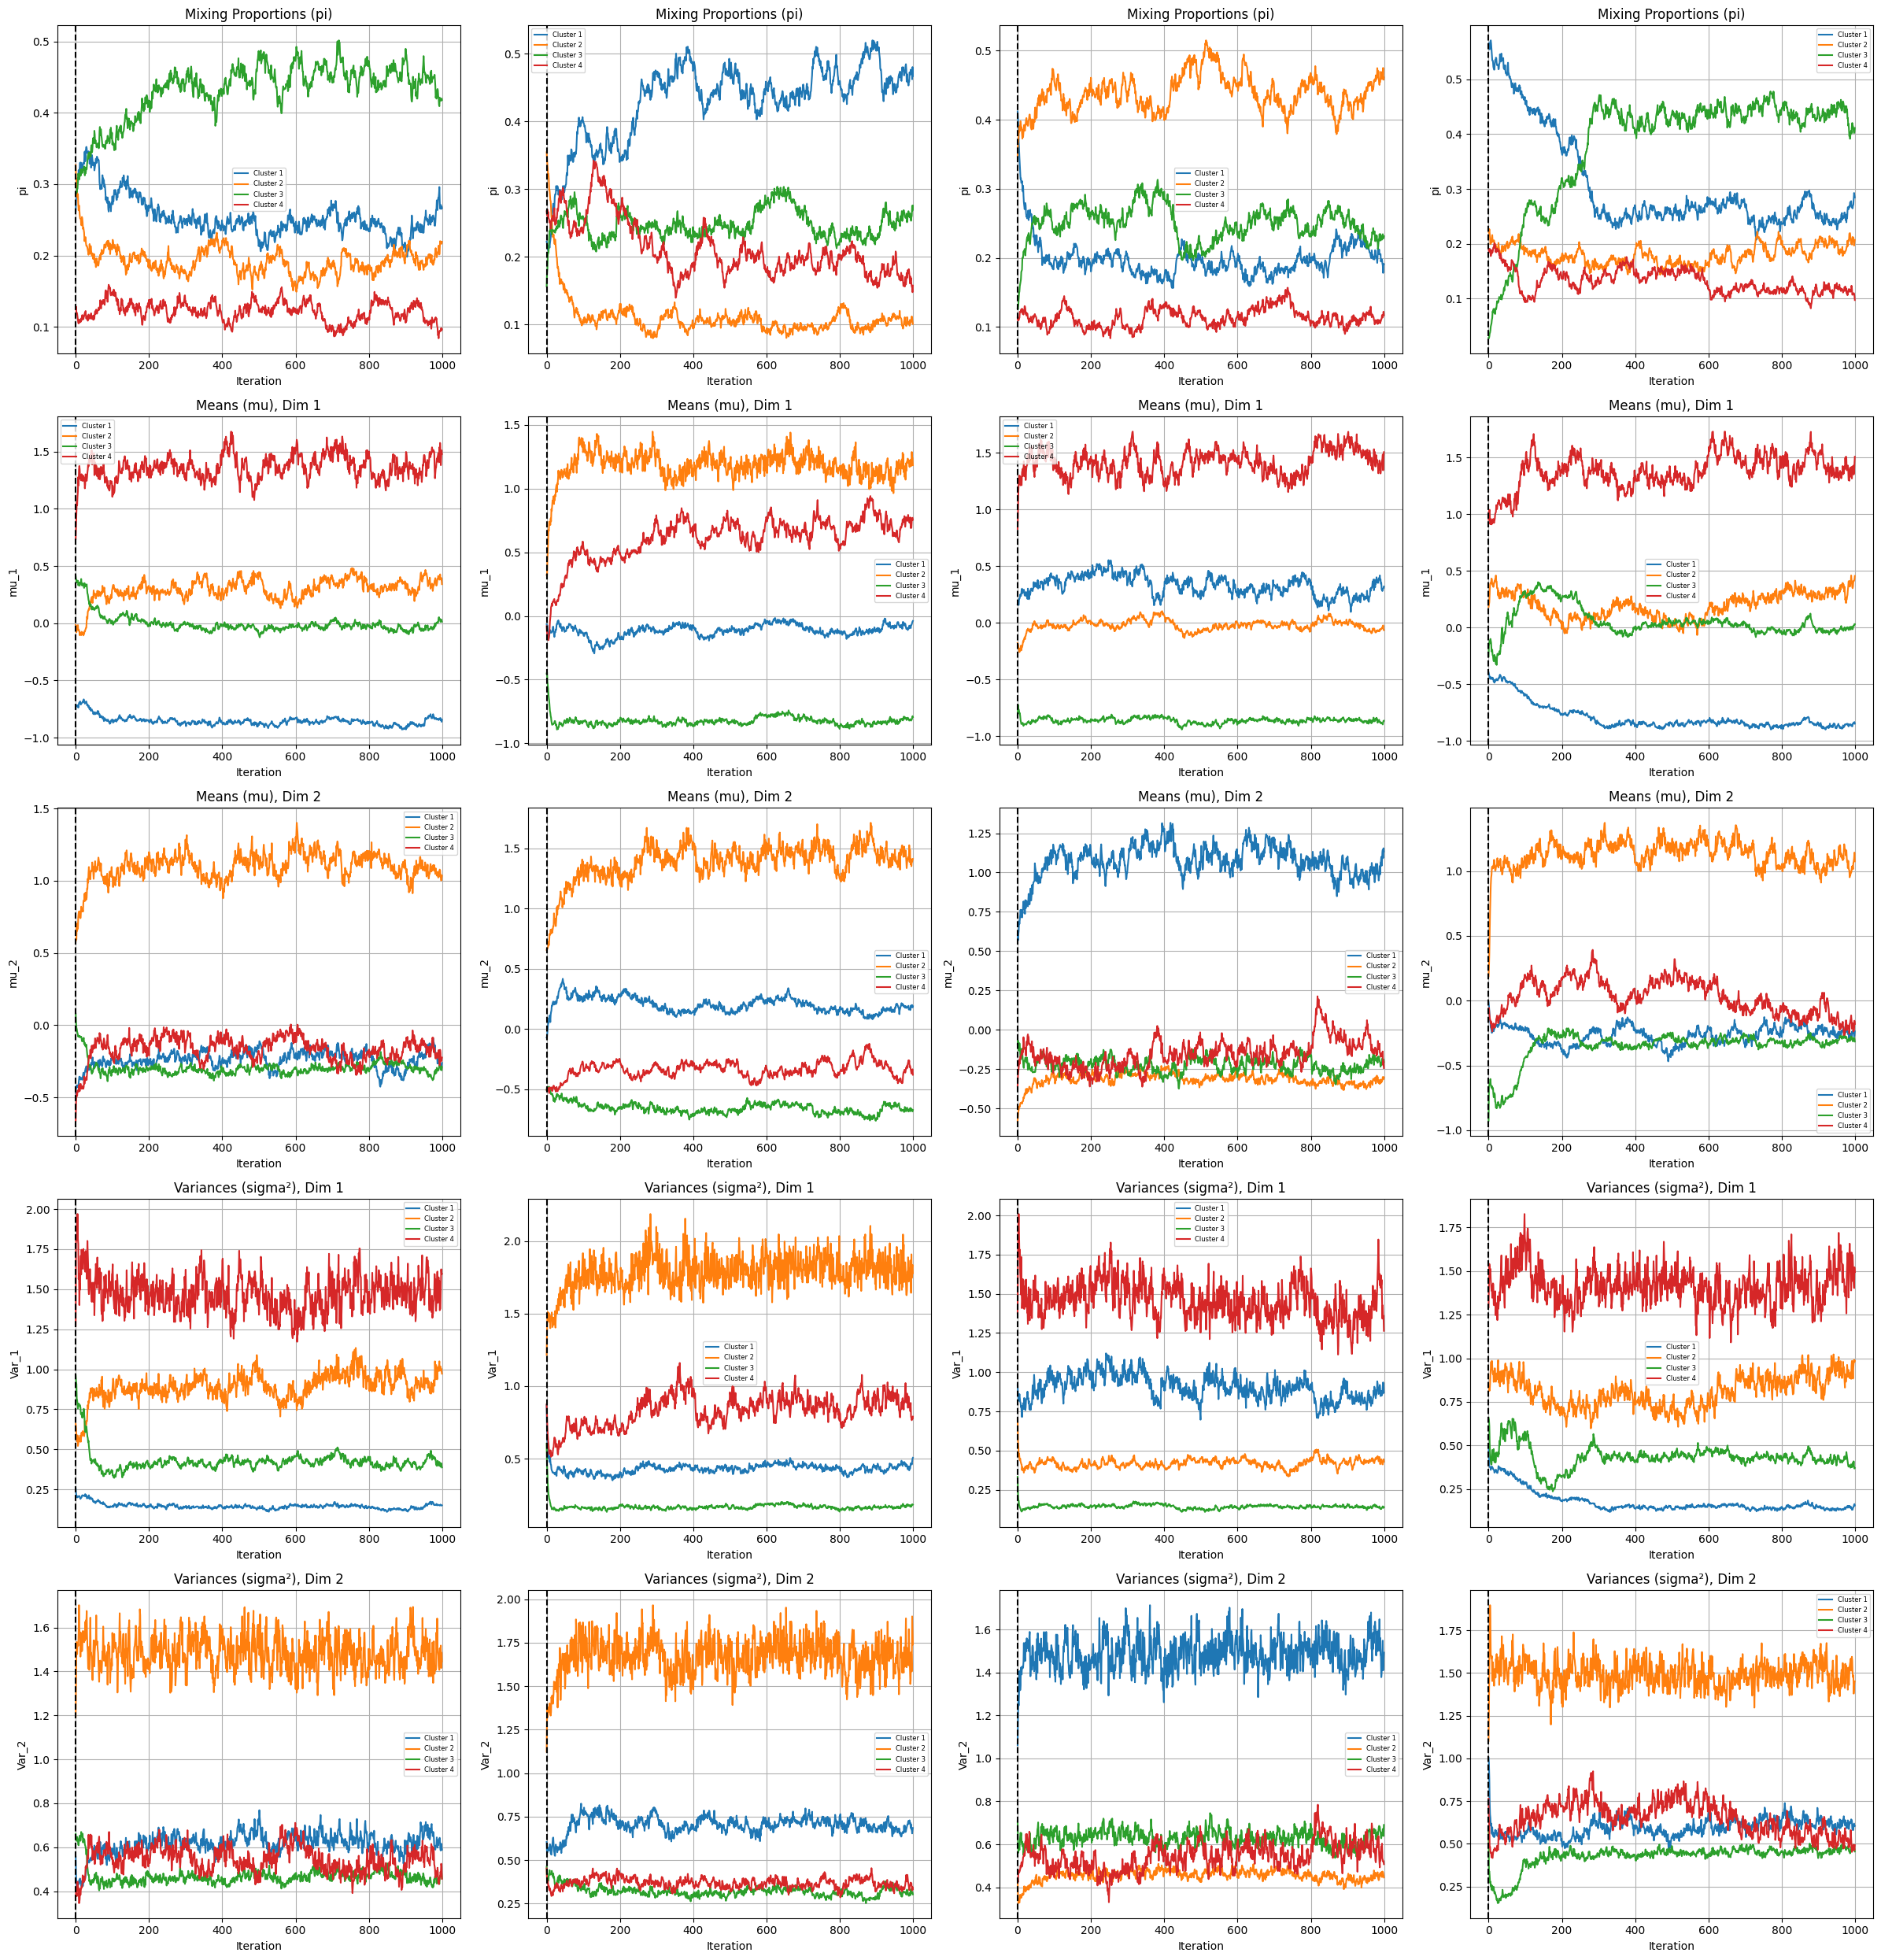

In [38]:
np.random.seed(42)
# Parameters
# num_runs = 4
num_iterations = 1000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 
sigma_vals = [0.01, 0.05, 0.1, 0.15]
num_runs = len(sigma_vals)
all_run_samples = []

for sig in sigma_vals:
    print(f"Running Gibbs Sampler for sigma = {sig}")
    run_samples = gibbs_sampler_gmm_multivariate(X, K, num_iterations, burn_in=0)
    all_run_samples.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=0)
plt.tight_layout()
plt.show()




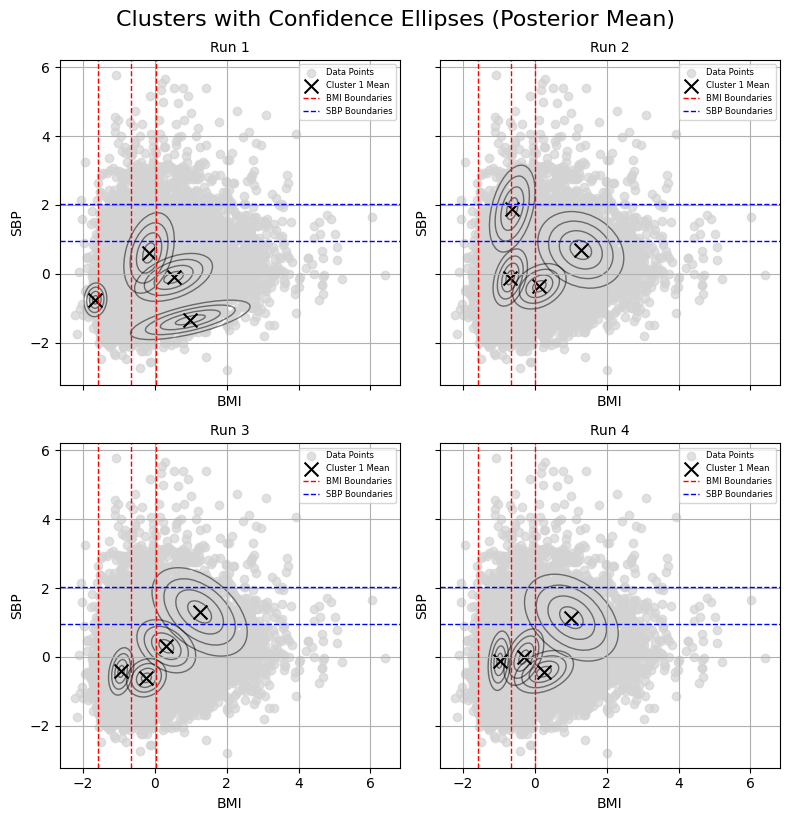

In [35]:
ellipse_mean(all_run_samples, X, bmi_bounds, sbp_bounds, burn_in=200)

In [30]:
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt

max_lags = 50
param_acfs = []

for run_samples in all_run_samples:
    # now that we know the means are in s[0]:
    trace = list(run_samples)   # or [s[j] for s in run_samples]
    acf_vals = acf(trace, nlags=max_lags, fft=True)
    param_acfs.append(acf_vals)

plt.figure(figsize=(10, 6))
for i, acf_vals in enumerate(param_acfs):
    plt.plot(acf_vals, label=f'σ = {sigma_vals[i]}')

plt.title("Autocorrelation of Cluster 0, Dim 0 vs σ")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (5000, 4) + inhomogeneous part.

Sampling: 100%|██████████| 1000/1000 [00:06<00:00, 143.97it/s]


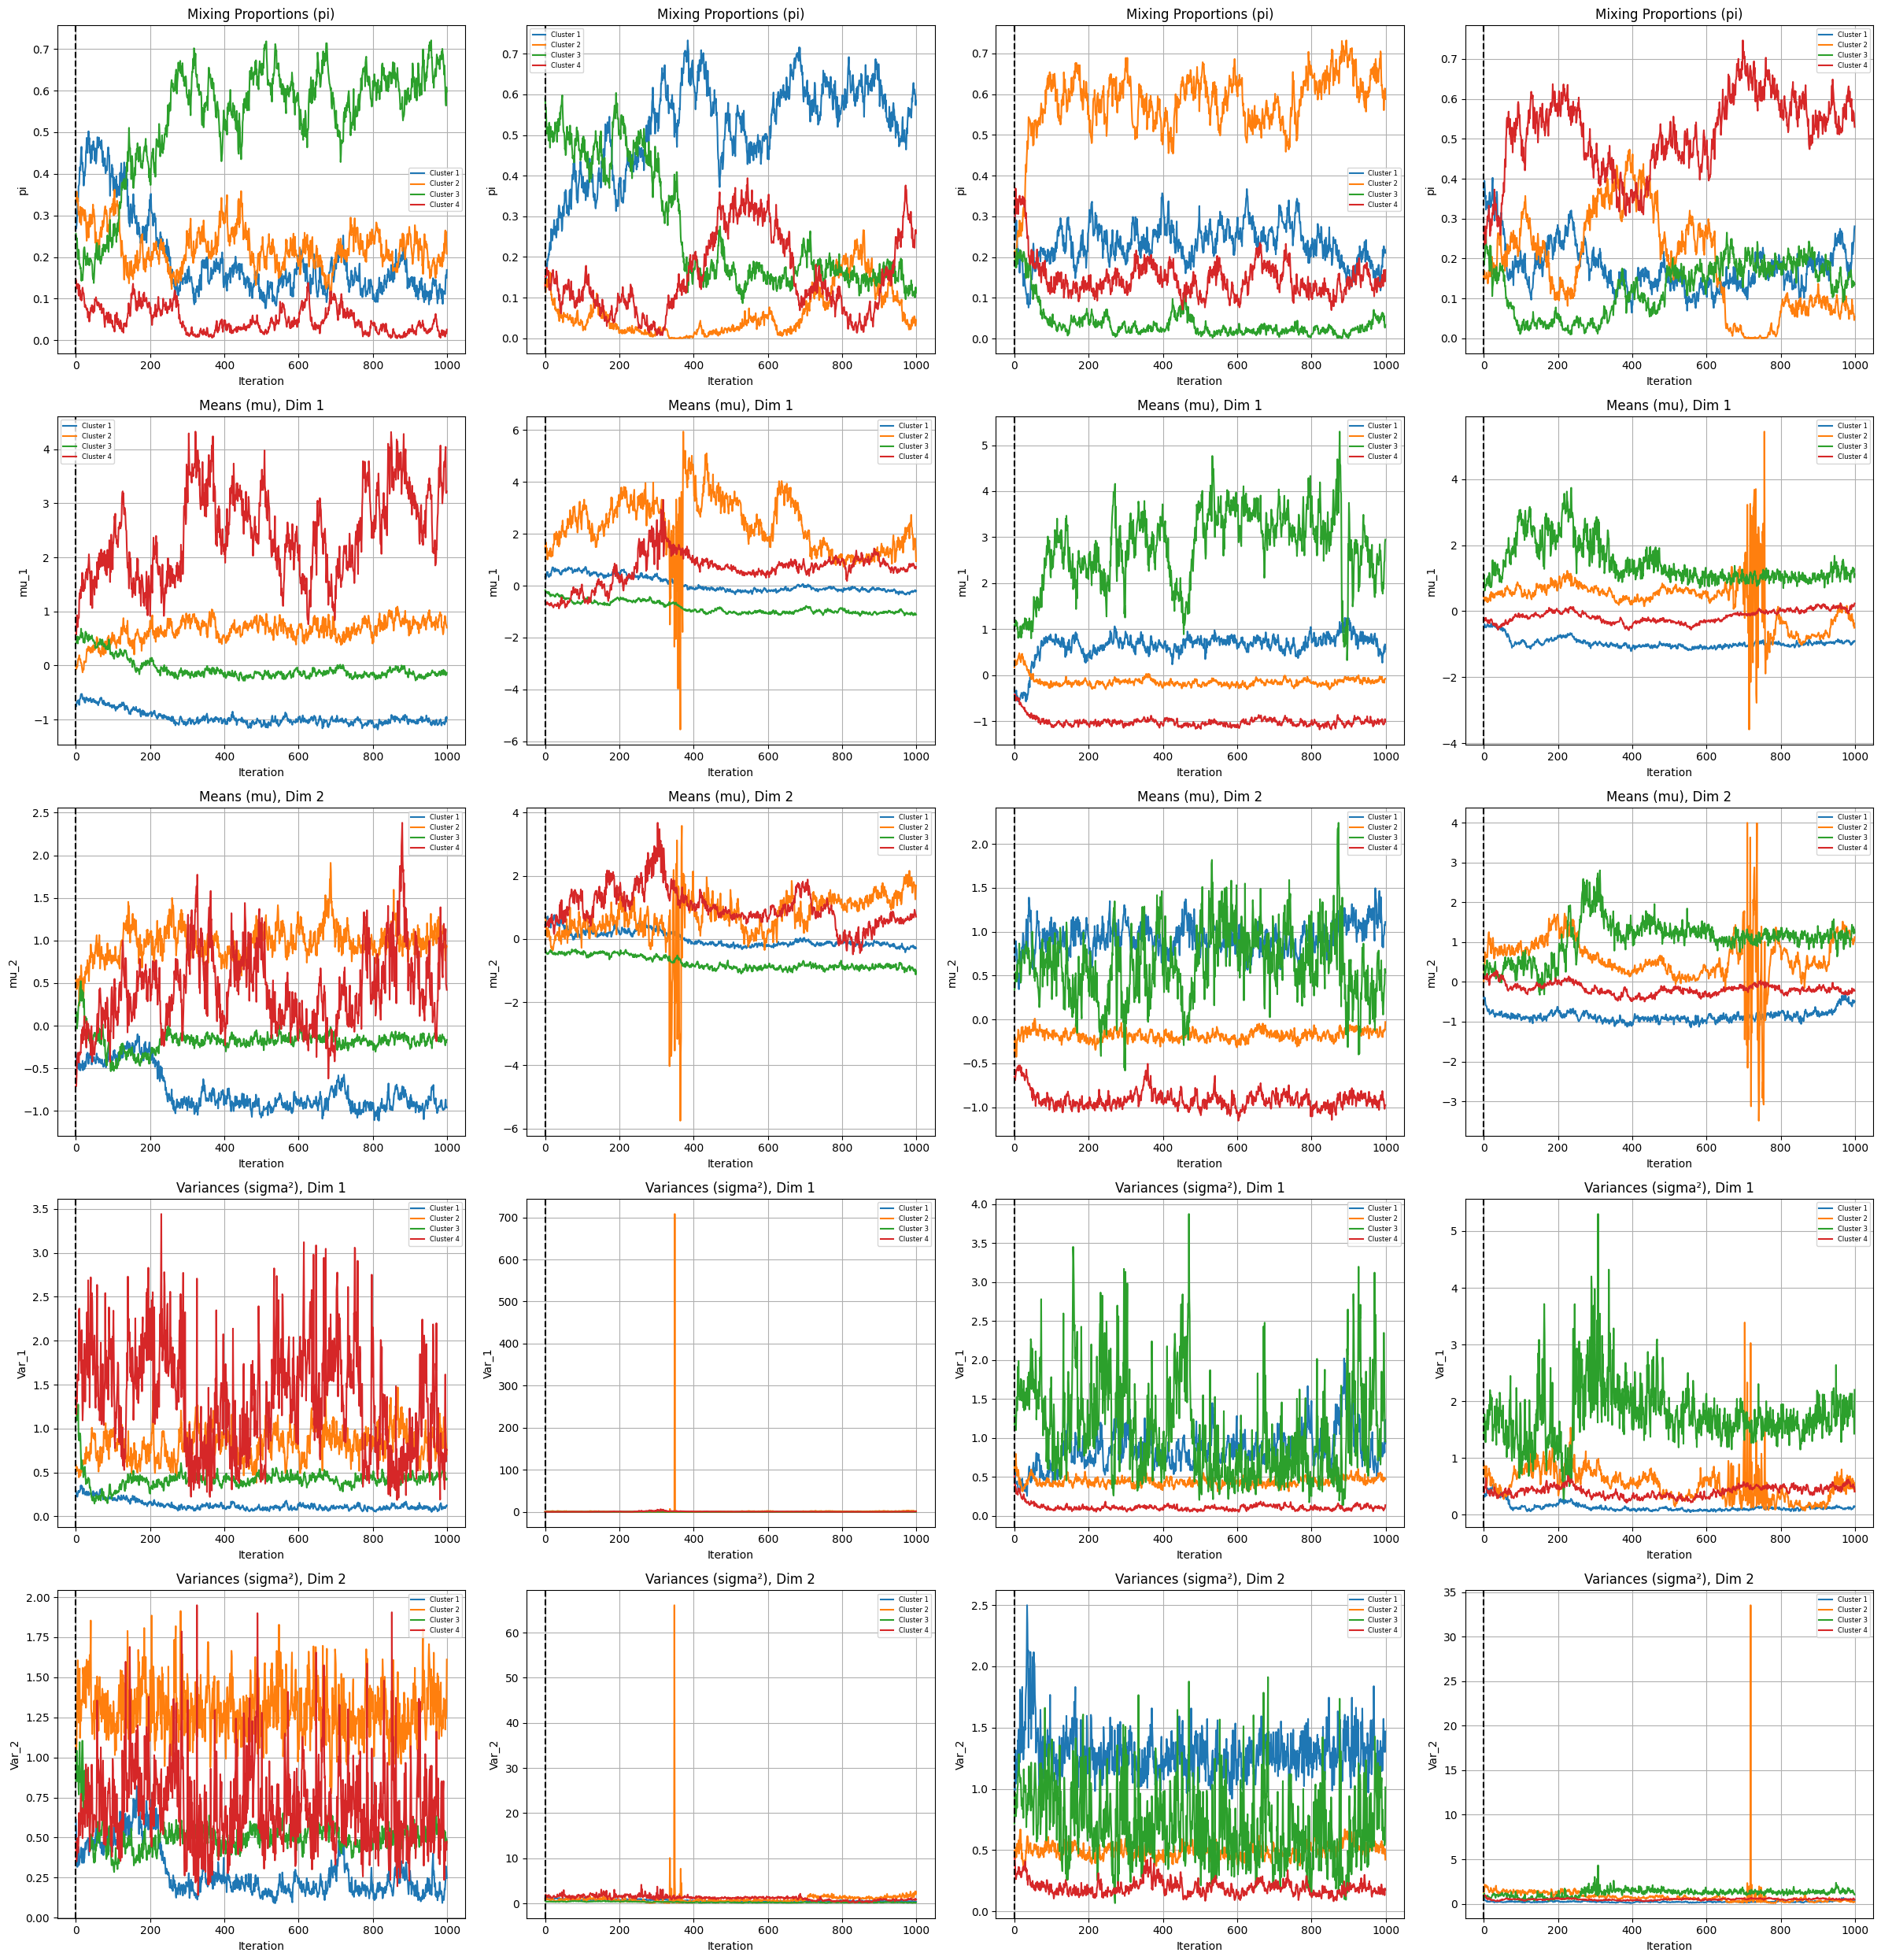

In [5]:
np.random.seed(42)
# Parameters
# num_runs = 2
num_iterations = 1000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 
num_runs = 4
all_run_samples = []

for i in range(num_runs):
    run_samples = gibbs_sampler_gmm_multivariate(X, K, num_iterations, 0)
    all_run_samples.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=0)
plt.tight_layout()
plt.show()




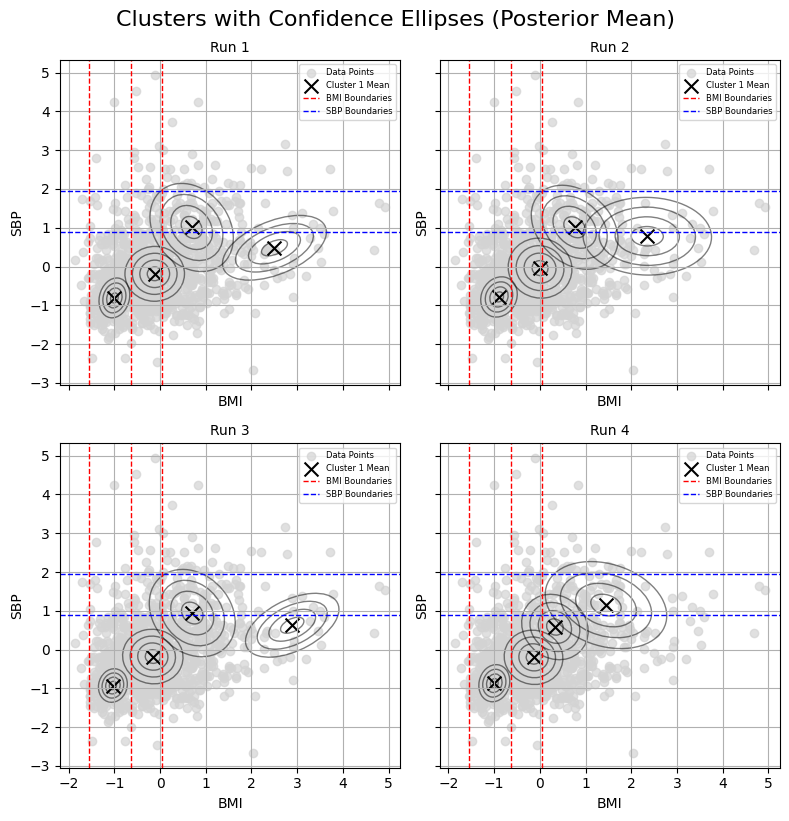

In [6]:
ellipse_mean(all_run_samples, X, bmi_bounds, sbp_bounds, burn_in=100)

In [7]:

def compute_ess(chain):
    """
    Compute effective sample size (ESS) for a univariate MCMC chain.
    
    Parameters:
        chain : ndarray
            1D array of samples.
            
    Returns:
        ess : float
            Effective sample size.
    """
    N = len(chain)
    chain_centered = chain - np.mean(chain)
    acf = [1.0]
    for lag in range(1, N):
        c = np.corrcoef(chain_centered[:-lag], chain_centered[lag:])[0, 1]
        if c < 0:
            break
        acf.append(c)
    return N / (1 + 2 * np.sum(acf[1:]))

# Suppose you have run your sampler and collected samples as follows:
# all_run_samples is a list of runs, each being a list of samples (pi, mu, Sigma, z)
# Let's assume you have chosen one run and applied burn-in:
# (This would typically be done after running your sampler.)
burn_in = 0
# Convert lists of samples into arrays for easy slicing:
# For example, mu_samples will have shape (T, K, p)
mu_samples = np.array([s[1] for s in all_run_samples[0][burn_in:]])
pi_samples = np.array([s[0] for s in all_run_samples[0][burn_in:]])


# You can loop over clusters and dimensions to compute ESS for all parameters.
for k in range(pi_samples.shape[1]):
    ess_pi = compute_ess(pi_samples[:, k])
    print(f"ESS for mixing proportions, cluster {k}: {ess_pi:.2f}")

for k in range(mu_samples.shape[1]):
    for dim in range(mu_samples.shape[2]):
        ess_mu = compute_ess(mu_samples[:, k, dim])
        print(f"ESS for cluster {k}, dimension {dim}: {ess_mu:.2f}")

ESS for mixing proportions, cluster 0: 3.03
ESS for mixing proportions, cluster 1: 20.37
ESS for mixing proportions, cluster 2: 2.90
ESS for mixing proportions, cluster 3: 11.23
ESS for cluster 0, dimension 0: 3.24
ESS for cluster 0, dimension 1: 3.90
ESS for cluster 1, dimension 0: 7.57
ESS for cluster 1, dimension 1: 25.48
ESS for cluster 2, dimension 0: 3.50
ESS for cluster 2, dimension 1: 18.13
ESS for cluster 3, dimension 0: 11.17
ESS for cluster 3, dimension 1: 15.33


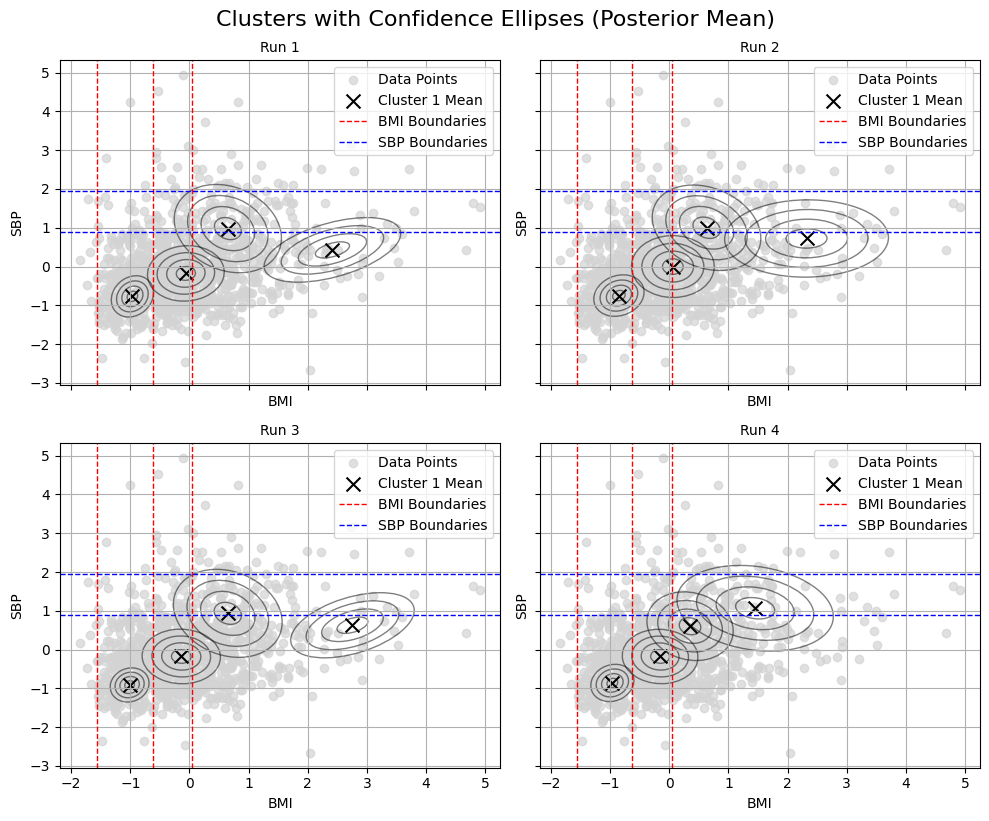

In [8]:
# Compute posterior estimates for each run using samples after burn-in
cols = 2  # Number of columns in the subplot grid
rows = (num_runs + cols - 1) // cols  # Calculate the required number of rows
fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows), sharex=True, sharey=True)
axes = np.array(axes).flatten()  # Flatten to 1D array for easy iteration

for run, (ax, run_samples) in enumerate(zip(axes, all_run_samples)):
    # Use samples after burn-in for this run:
    run_samples_burned = run_samples[burn_in:]
    # Extract cluster means and covariances from the post-burn-in samples:
    mu_samples = np.array([s[1] for s in run_samples_burned])       # shape: (T, K, p)
    sigma_samples = np.array([s[2] for s in run_samples_burned])    # shape: (T, K, p, p)
    
    # Compute the posterior (averaged) estimates:
    posterior_mu = np.mean(mu_samples, axis=0)       # shape: (K, p)
    posterior_sigma = np.mean(sigma_samples, axis=0) # shape: (K, p, p)
    
    # Our plotting function expects sample arrays; we can wrap these in a singleton dimension.
    plot_with_reference_lines(np.expand_dims(posterior_mu, axis=0),
                              np.expand_dims(posterior_sigma, axis=0),
                              X, bmi_bounds, sbp_bounds, ax=ax) 
    ax.set_title(f"Run {run + 1}", fontsize=10)

plt.tight_layout()
plt.suptitle("Clusters with Confidence Ellipses (Posterior Mean)", fontsize=16, y=1.02)
plt.show()

In [9]:

burn_in = 1000
# Convert lists of samples into arrays for easy slicing:
# For example, mu_samples will have shape (T, K, p)
mu_samples = np.array([s[1] for s in all_run_samples[0][burn_in:]])
pi_samples = np.array([s[0] for s in all_run_samples[0][burn_in:]])


# You can loop over clusters and dimensions to compute ESS for all parameters.
for k in range(pi_samples.shape[1]):
    ess_pi = compute_ess(pi_samples[:, k])
    print(f"ESS for mixing proportions, cluster {k}: {ess_pi:.2f}")

for k in range(mu_samples.shape[1]):
    for dim in range(mu_samples.shape[2]):
        ess_mu = compute_ess(mu_samples[:, k, dim])
        print(f"ESS for cluster {k}, dimension {dim}: {ess_mu:.2f}")

IndexError: tuple index out of range

In [ ]:
ellipse_lastit(all_run_samples, X, bmi_bounds, sbp_bounds, burn_in)

NameError: name 'ellipse_lastit' is not defined

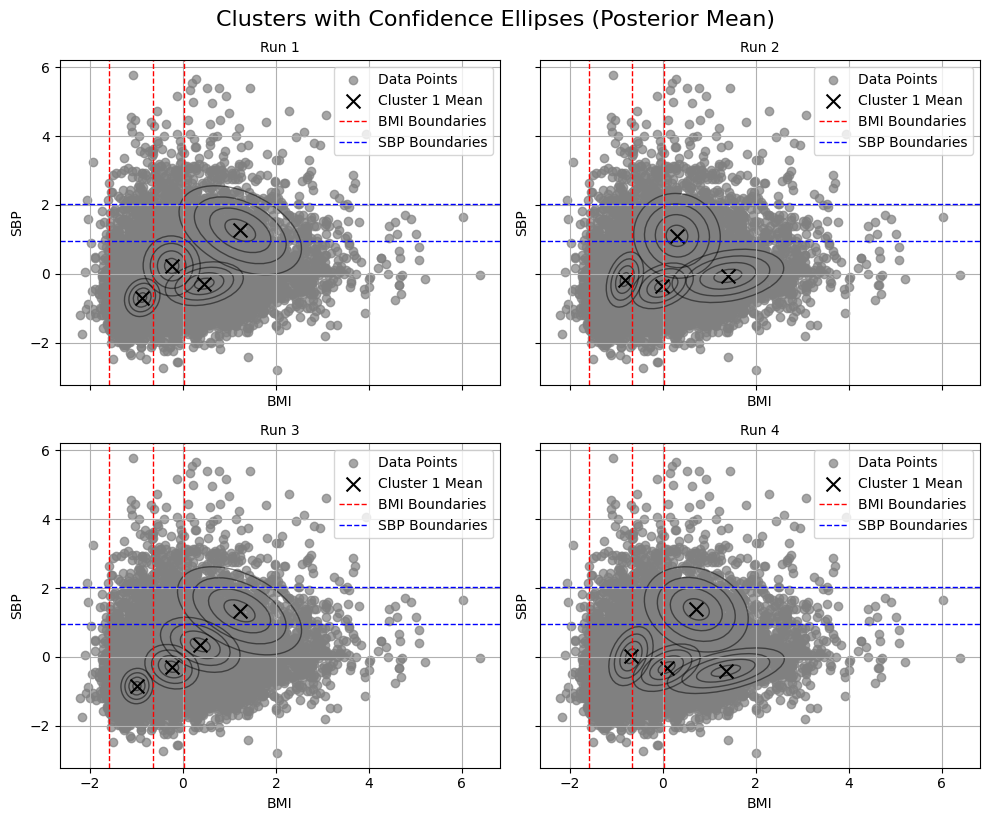

In [ ]:
# Compute posterior estimates for each run using samples after burn-in
cols = 2  # Number of columns in the subplot grid
rows = (num_runs + cols - 1) // cols  # Calculate the required number of rows
fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows), sharex=True, sharey=True)
axes = np.array(axes).flatten()  # Flatten to 1D array for easy iteration

for run, (ax, run_samples) in enumerate(zip(axes, all_run_samples)):
    # Use samples after burn-in for this run:
    run_samples_burned = run_samples[burn_in:]
    # Extract cluster means and covariances from the post-burn-in samples:
    mu_samples = np.array([s[1] for s in run_samples_burned])       # shape: (T, K, p)
    sigma_samples = np.array([s[2] for s in run_samples_burned])    # shape: (T, K, p, p)
    
    # Compute the posterior (averaged) estimates:
    posterior_mu = np.mean(mu_samples, axis=0)       # shape: (K, p)
    posterior_sigma = np.mean(sigma_samples, axis=0) # shape: (K, p, p)
    
    # Our plotting function expects sample arrays; we can wrap these in a singleton dimension.
    plot_with_reference_lines(np.expand_dims(posterior_mu, axis=0),
                              np.expand_dims(posterior_sigma, axis=0),
                              X, bmi_bounds, sbp_bounds, ax=ax) 
    ax.set_title(f"Run {run + 1}", fontsize=10)

plt.tight_layout()
plt.suptitle("Clusters with Confidence Ellipses (Posterior Mean)", fontsize=16, y=1.02)
plt.show()

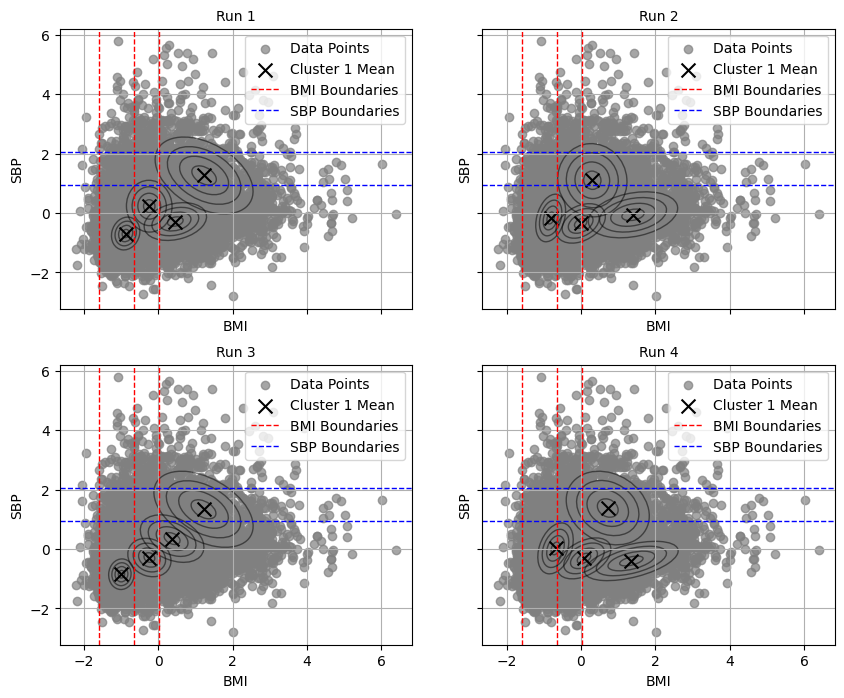

In [ ]:
# Compute posterior estimates using only samples after burn-in for one run
run_samples_burned = all_run_samples[0][burn_in:]
pi_samples = np.array([s[0] for s in run_samples_burned])
mu_samples = np.array([s[1] for s in run_samples_burned])
sigma_samples = np.array([s[2] for s in run_samples_burned])

posterior_pi = pi_samples[-1]
posterior_mu = mu_samples[-1]
posterior_sigma = sigma_samples[-1]


# Plot final clustering with ellipses using the computed posterior estimates
cols = 2  # Number of columns in the subplot grid
rows = (num_runs + cols - 1) // cols  # Calculate the required number of rows
fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows), sharex=True, sharey=True)
axes = np.array(axes).flatten()  # Flatten to 1D array for easy iteration

for run, (ax, run_samples) in enumerate(zip(axes, all_run_samples)):
    mu_samples = np.array([s[1] for s in run_samples])  # Extract cluster means
    sigma_samples = np.array([s[2] for s in run_samples])  # Extract cluster covariances
    # Plot the clustering with confidence ellipses on the given axis.
    plot_with_reference_lines(mu_samples, sigma_samples, X, bmi_bounds, sbp_bounds, ax=ax)
    ax.set_title(f"Run {run + 1}", fontsize=10)


In [ ]:
np.random.seed(42)
# Parameters
num_runs = 4
num_iterations = 4000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 

all_run_samples = []

for run in range(num_runs):
    print(f"Running Gibbs Sampler for Run {run + 1}")
    run_samples = bayesian_repulsive(X, K, num_iterations, h1, 0, bmi_bounds, sbp_bounds)
    all_run_samples.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=0)
plt.tight_layout()
plt.show()




Running Gibbs Sampler for Run 1


NameError: name 'bayesian_repulsive' is not defined

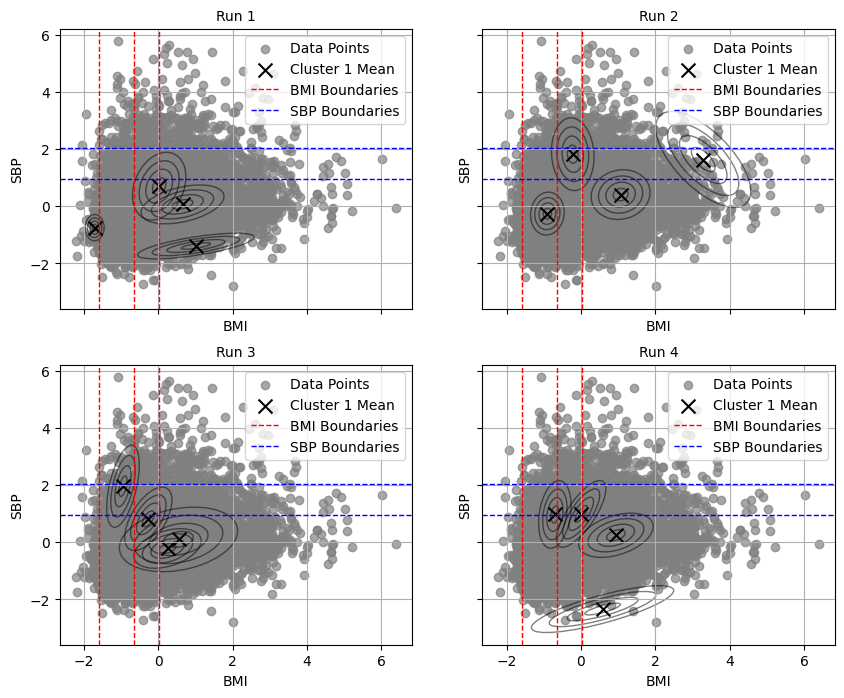

In [ ]:

pi_samples = np.array([s[0] for s in all_run_samples[0]])
mu_samples = np.array([s[1] for s in all_run_samples[0]])
sigma_samples = np.array([s[2] for s in all_run_samples[0]])

posterior_pi = pi_samples[-1]
posterior_mu = mu_samples[-1]
posterior_sigma = sigma_samples[-1]


# Plot final clustering with ellipses using the computed posterior estimates
cols = 2  # Number of columns in the subplot grid
rows = (num_runs + cols - 1) // cols  # Calculate the required number of rows
fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows), sharex=True, sharey=True)
axes = np.array(axes).flatten()  # Flatten to 1D array for easy iteration

for run, (ax, run_samples) in enumerate(zip(axes, all_run_samples)):
    mu_samples = np.array([s[1] for s in run_samples])  # Extract cluster means
    sigma_samples = np.array([s[2] for s in run_samples])  # Extract cluster covariances
    # Plot the clustering with confidence ellipses on the given axis.
    plot_with_reference_lines(mu_samples, sigma_samples, X, bmi_bounds, sbp_bounds, ax=ax)
    ax.set_title(f"Run {run + 1}", fontsize=10)


In [ ]:
def h1(mu):
    return np.min(pdist(mu))*2

Running Gibbs Sampler for Run 1


Sampling: 100%|██████████| 4000/4000 [04:37<00:00, 14.42it/s]


Running Gibbs Sampler for Run 2


Sampling: 100%|██████████| 4000/4000 [04:39<00:00, 14.32it/s]


Running Gibbs Sampler for Run 3


Sampling: 100%|██████████| 4000/4000 [04:39<00:00, 14.31it/s]


Running Gibbs Sampler for Run 4


Sampling: 100%|██████████| 4000/4000 [04:45<00:00, 13.99it/s]


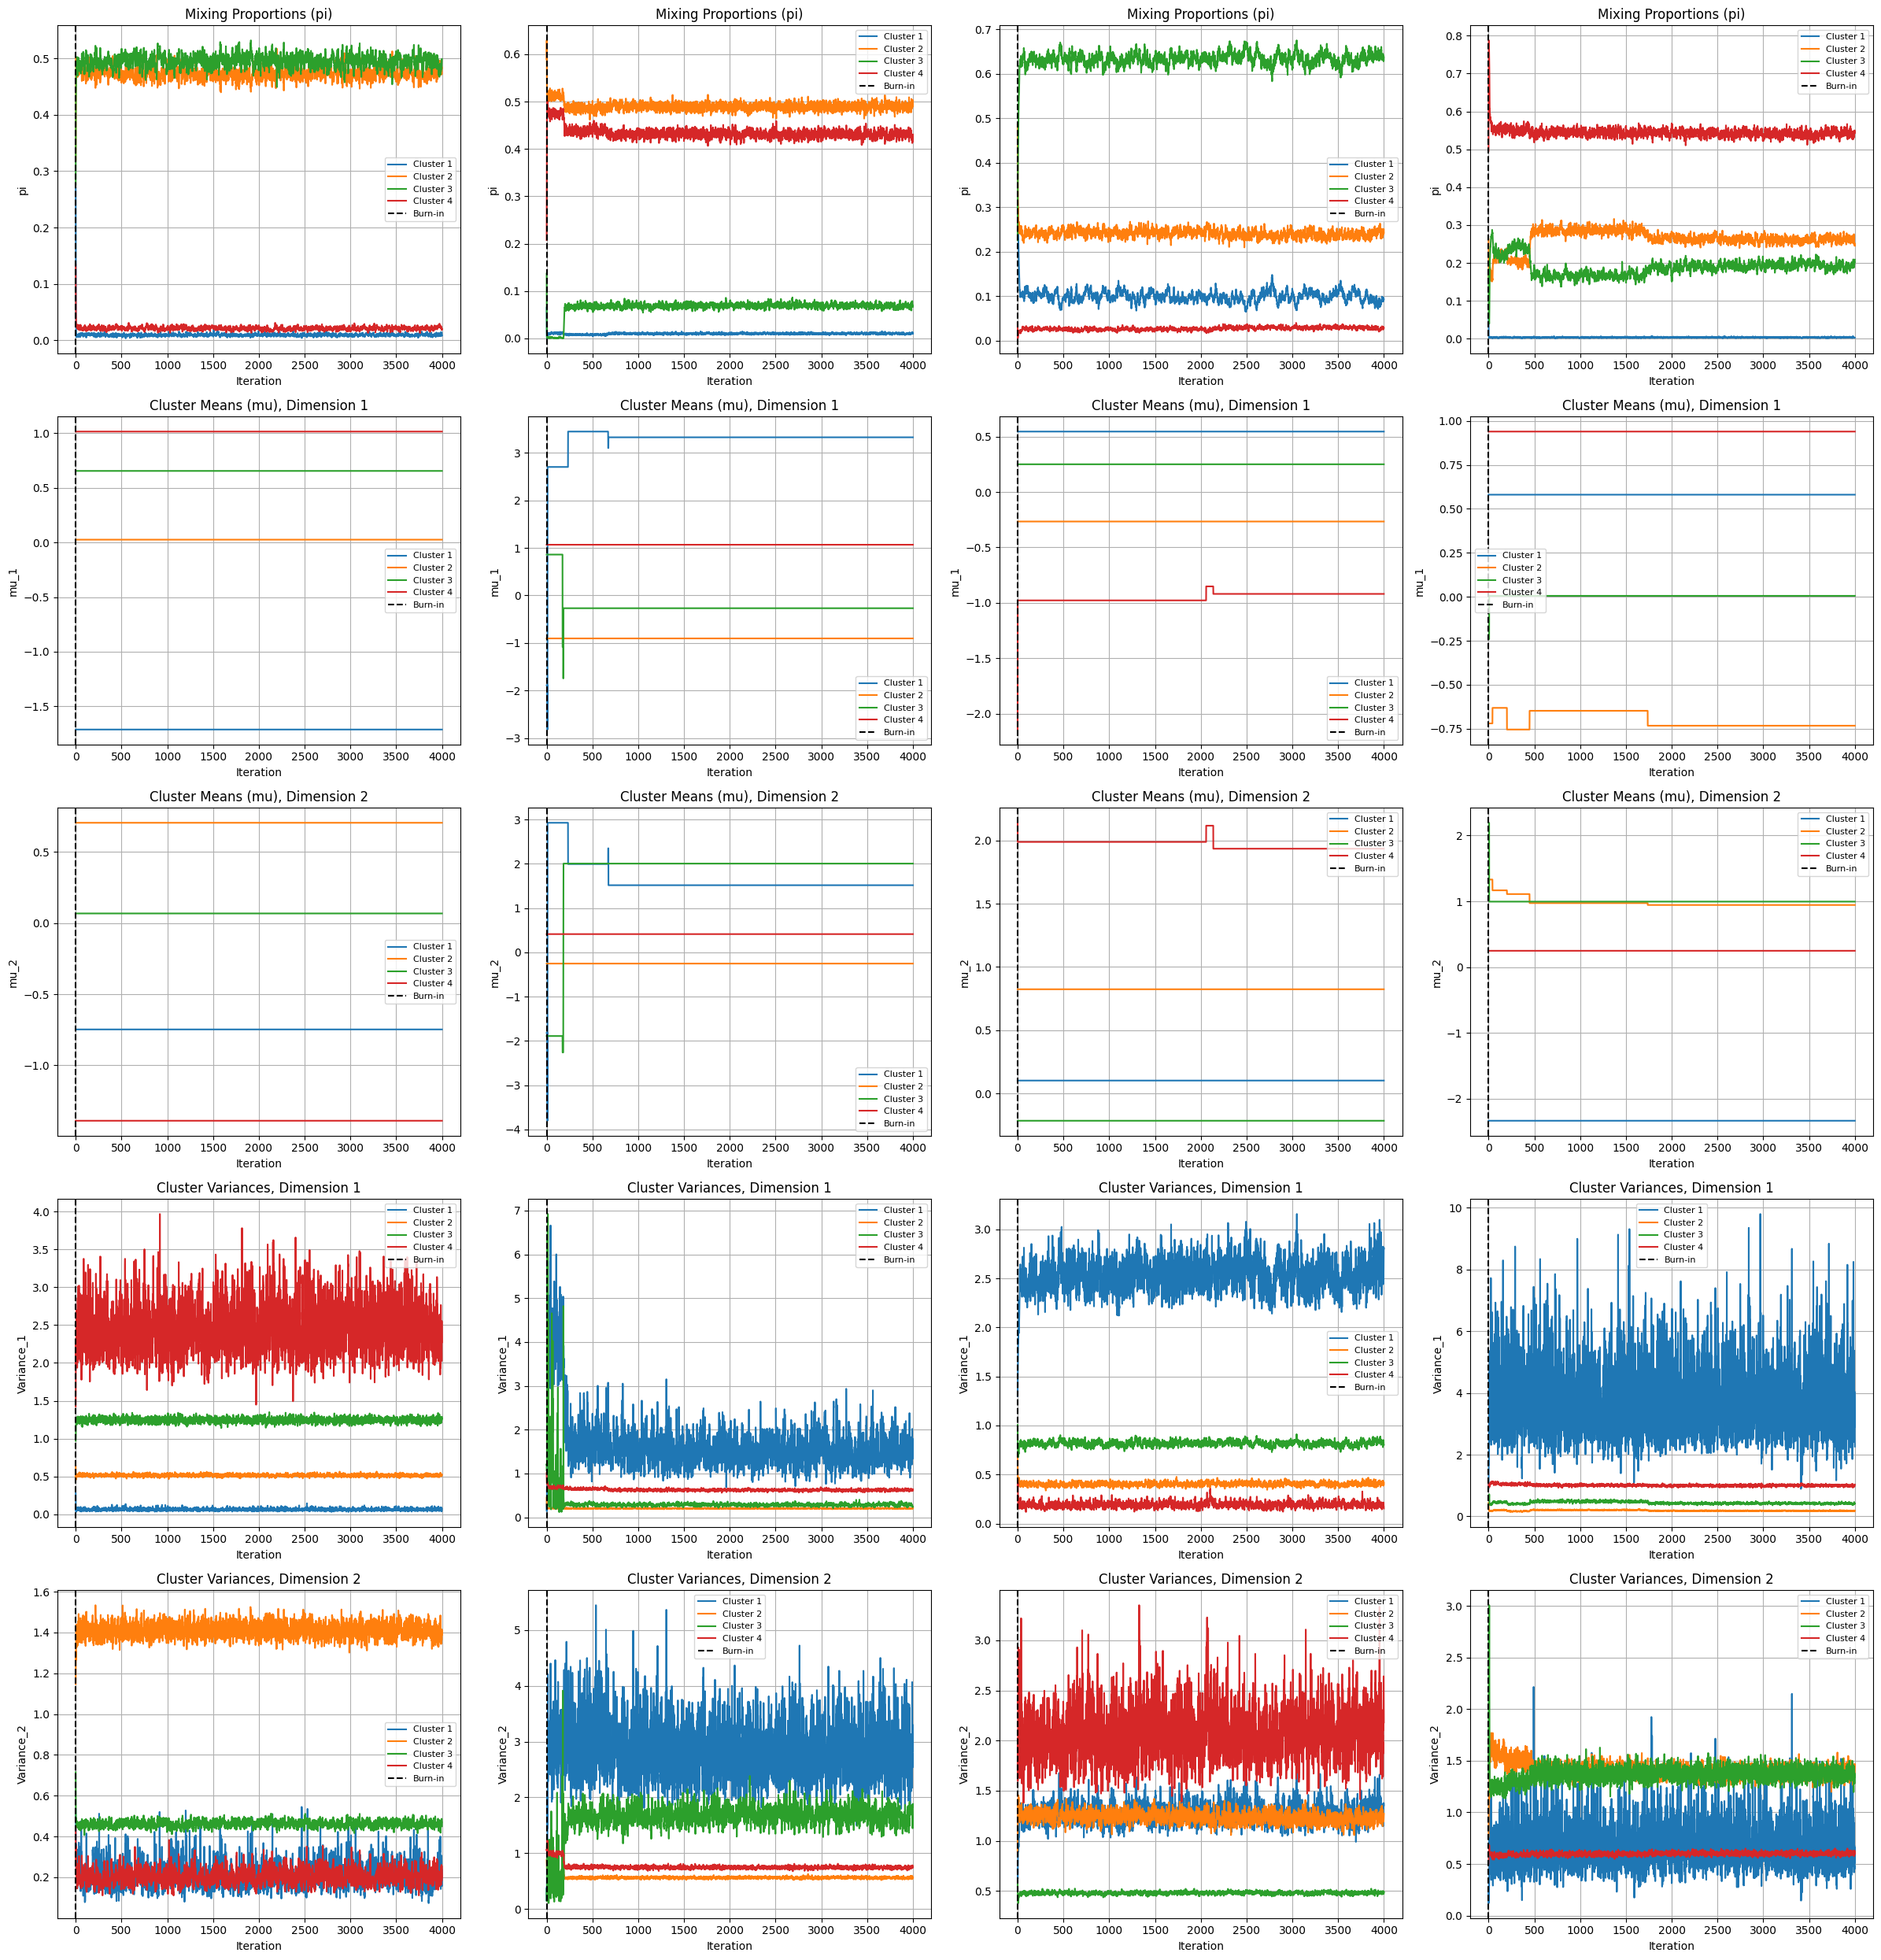

In [ ]:
np.random.seed(42)
# Parameters
num_runs = 4
num_iterations = 4000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 

all_run_samples = []

for run in range(num_runs):
    print(f"Running Gibbs Sampler for Run {run + 1}")
    run_samples = bayesian_repulsive(X, K, num_iterations, h1, 0, bmi_bounds, sbp_bounds)
    all_run_samples.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=0)
plt.tight_layout()
plt.show()




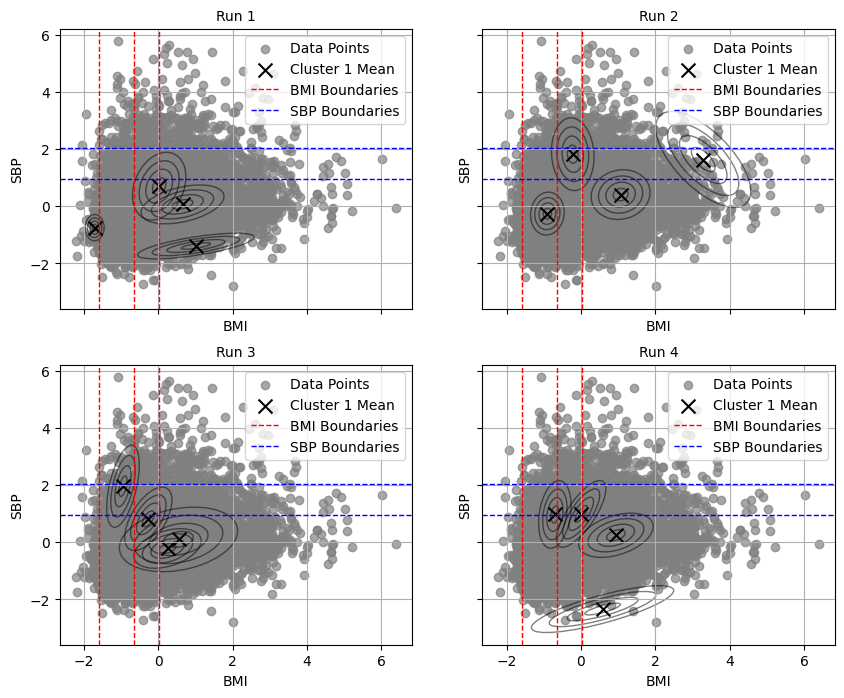

In [ ]:

pi_samples = np.array([s[0] for s in all_run_samples[0]])
mu_samples = np.array([s[1] for s in all_run_samples[0]])
sigma_samples = np.array([s[2] for s in all_run_samples[0]])

posterior_pi = pi_samples[-1]
posterior_mu = mu_samples[-1]
posterior_sigma = sigma_samples[-1]


# Plot final clustering with ellipses using the computed posterior estimates
cols = 2  # Number of columns in the subplot grid
rows = (num_runs + cols - 1) // cols  # Calculate the required number of rows
fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows), sharex=True, sharey=True)
axes = np.array(axes).flatten()  # Flatten to 1D array for easy iteration

for run, (ax, run_samples) in enumerate(zip(axes, all_run_samples)):
    mu_samples = np.array([s[1] for s in run_samples])  # Extract cluster means
    sigma_samples = np.array([s[2] for s in run_samples])  # Extract cluster covariances
    # Plot the clustering with confidence ellipses on the given axis.
    plot_with_reference_lines(mu_samples, sigma_samples, X, bmi_bounds, sbp_bounds, ax=ax)
    ax.set_title(f"Run {run + 1}", fontsize=10)


Running Gibbs Sampler for Run 1


Sampling: 100%|██████████| 3000/3000 [03:31<00:00, 14.18it/s]


Running Gibbs Sampler for Run 2


Sampling: 100%|██████████| 3000/3000 [03:32<00:00, 14.13it/s]


Running Gibbs Sampler for Run 3


Sampling: 100%|██████████| 3000/3000 [03:31<00:00, 14.18it/s]


Running Gibbs Sampler for Run 4


Sampling: 100%|██████████| 3000/3000 [03:30<00:00, 14.26it/s]


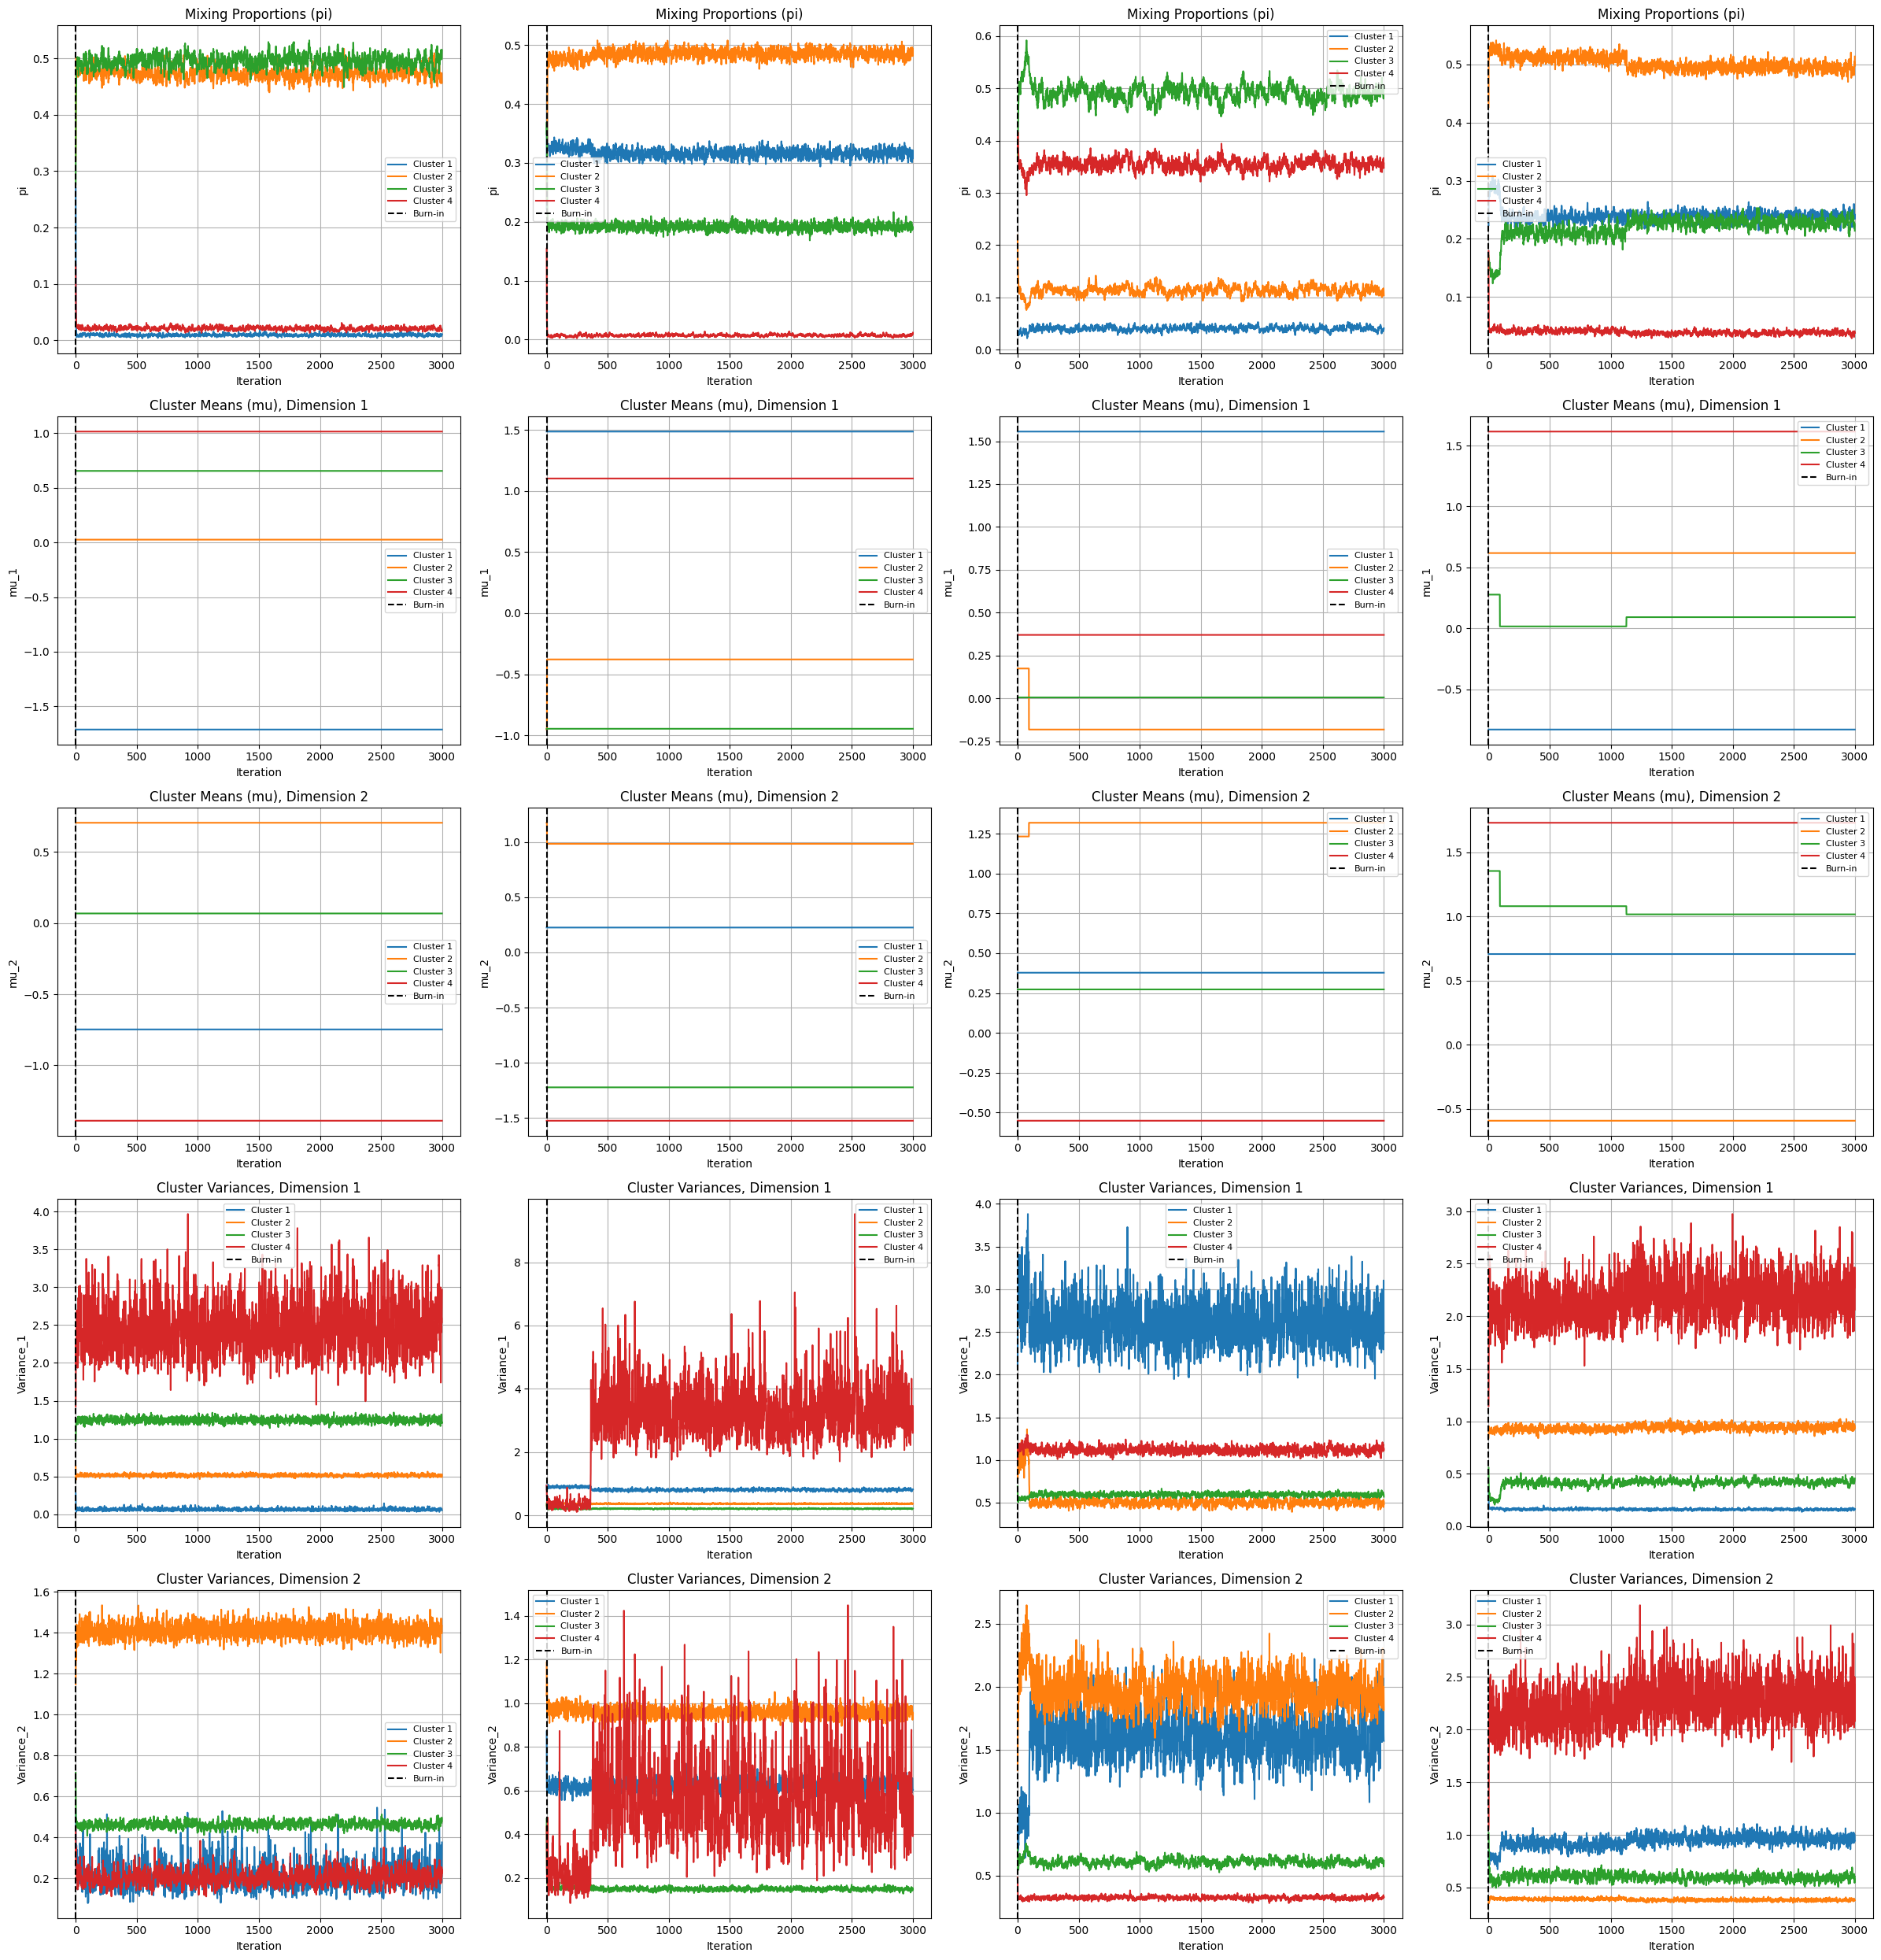

In [ ]:
def h1(mu):
    return np.min(pdist(mu))*3
np.random.seed(42)
# Parameters
num_runs = 4
num_iterations = 3000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 

all_run_samples = []

for run in range(num_runs):
    print(f"Running Gibbs Sampler for Run {run + 1}")
    run_samples = bayesian_repulsive(X, K, num_iterations, h1, 0, bmi_bounds, sbp_bounds)
    all_run_samples.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=0)
plt.tight_layout()
plt.show()




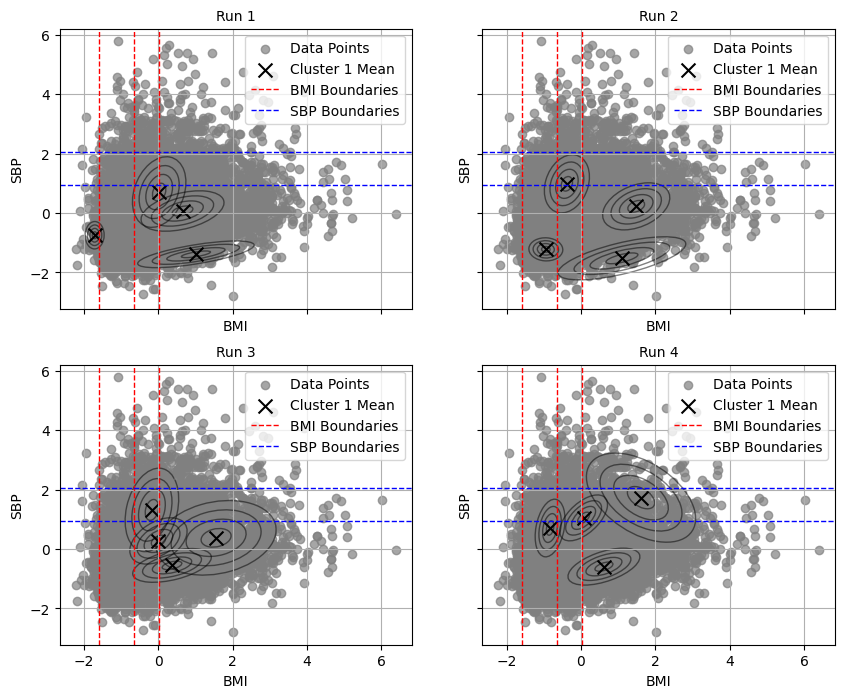

In [ ]:
§
pi_samples = np.array([s[0] for s in all_run_samples[0]])
mu_samples = np.array([s[1] for s in all_run_samples[0]])
sigma_samples = np.array([s[2] for s in all_run_samples[0]])

posterior_pi = pi_samples[-1]
posterior_mu = mu_samples[-1]
posterior_sigma = sigma_samples[-1]


# Plot final clustering with ellipses using the computed posterior estimates
cols = 2  # Number of columns in the subplot grid
rows = (num_runs + cols - 1) // cols  # Calculate the required number of rows
fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows), sharex=True, sharey=True)
axes = np.array(axes).flatten()  # Flatten to 1D array for easy iteration

for run, (ax, run_samples) in enumerate(zip(axes, all_run_samples)):
    mu_samples = np.array([s[1] for s in run_samples])  # Extract cluster means
    sigma_samples = np.array([s[2] for s in run_samples])  # Extract cluster covariances
    # Plot the clustering with confidence ellipses on the given axis.
    plot_with_reference_lines(mu_samples, sigma_samples, X, bmi_bounds, sbp_bounds, ax=ax)
    ax.set_title(f"Run {run + 1}", fontsize=10)
